# Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов

<b>Цель.</b> В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>

<b>Подготовка:</b>
</br>1. Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
</br>2. Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха).
</br>3. По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html).

<b>Моделирование:</b>
</br>Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).
</br>4. Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек.
</br>5. Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть.
</br>6. Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня.
</br>7. Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными.
</br>8. А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза.

<b>Несколько советов:</b>
* для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным;
* попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки.
* Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза.
* Теперь вы круто разбираетесь в прогнозировании и временных рядах :)

# Выполнение

<b>Подготовка данных</b>

Сначала импортируем необходимые библиотеки и загрузим датасет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка данных
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# Оставляем только необходимые столбцы
data = data[['date_time', 'traffic_volume', 'holiday', 'temp']]

# Преобразуем date_time в формат datetime
data['date_time'] = pd.to_datetime(data['date_time'])

# Устанавливаем date_time как индекс
data.set_index('date_time', inplace=True)

# Просмотрим несколько строк данных
data.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,NaN,288.28
2012-10-02 10:00:00,4516,NaN,289.36
2012-10-02 11:00:00,4767,NaN,289.58
2012-10-02 12:00:00,5026,NaN,290.13
2012-10-02 13:00:00,4918,NaN,291.14


<b>Базовый EDA</b>

Проведем базовый анализ данных, чтобы понять их структуру. Убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час.

traffic_volume        0
holiday           48143
temp                  0
dtype: int64
       traffic_volume          temp
count    48204.000000  48204.000000
mean      3259.818355    281.205870
std       1986.860670     13.338232
min          0.000000      0.000000
25%       1193.000000    272.160000
50%       3380.000000    282.450000
75%       4933.000000    291.806000
max       7280.000000    310.070000
Количество дубликатов: 7598


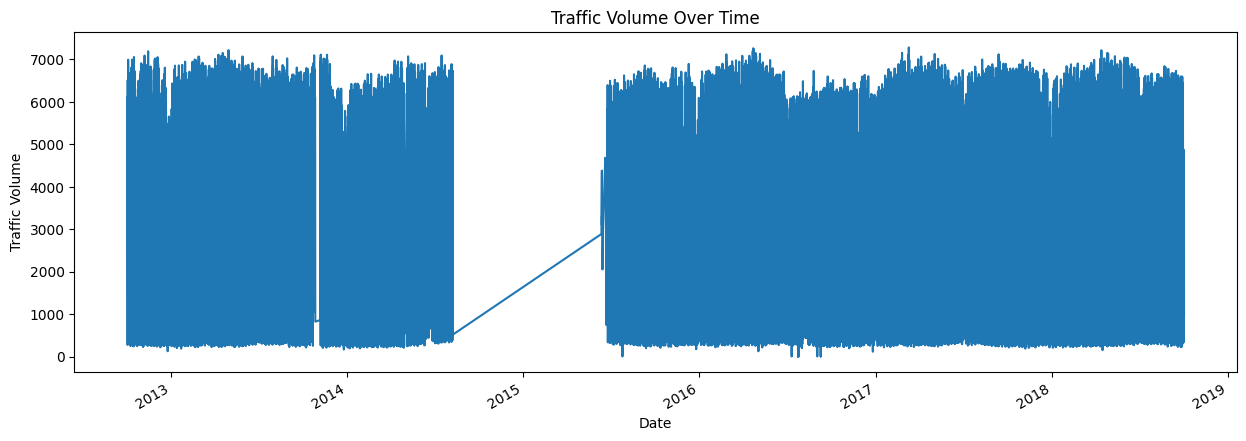

In [3]:
# Проверим наличие пропусков
print(data.isnull().sum())

# Статистическое описание данных
print(data.describe())

# Проверим дубликаты
duplicates = data.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')

# Визуализируем временной ряд traffic_volume
plt.figure(figsize=(15, 5))
data['traffic_volume'].plot()
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.show()

<b>Проверка равномерности временных интервалов и заполнение пропусков.</b>

Дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции.

In [4]:
# Удалим дубликаты
data = data[~data.index.duplicated(keep='first')]

In [5]:
# Создадим полный временной индекс с шагом в 1 час
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='h')

# Реиндексируем данные
data = data.reindex(full_index)

# Преобразуем типы данных, чтобы интерполяция работала корректно
data['holiday'] = data['holiday'].astype('object')
data[['traffic_volume', 'temp']] = data[['traffic_volume', 'temp']].apply(pd.to_numeric)

# Заполним пропуски линейной интерполяцией только для числовых столбцов
data[['traffic_volume', 'temp']] = data[['traffic_volume', 'temp']].interpolate(method='linear')

# Заполним пропуски в столбце holiday методом forward fill и backfill
data['holiday'] = data['holiday'].bfill().ffill()

# Проверим на наличие пропусков
print(data.isnull().sum())

traffic_volume    0
holiday           0
temp              0
dtype: int64


<b>Отложим последние две недели данных для тестирования модели</b>

In [6]:
# Отделим последние две недели данных для тестирования
test_data = data[-2*7*24:]
train_data = data[:-2*7*24]

print(f'Train data: {train_data.shape}')
print(f'Test data: {test_data.shape}')

Train data: (52215, 3)
Test data: (336, 3)


<b>Генерация дополнительных признаков</b>

Создадим новые признаки, такие как день недели и час дня:

In [7]:
# Генерация признаков из индекса с использованием .assign
train_data = train_data.assign(
    weekday=train_data.index.weekday,
    hour=train_data.index.hour
)

test_data = test_data.assign(
    weekday=test_data.index.weekday,
    hour=test_data.index.hour
)

# Просмотрим обновленные данные
train_data.head()

,traffic_volume,holiday,temp,weekday,hour
2012-10-02 09:00:00,5545.0,Columbus Day,288.28,1,9
2012-10-02 10:00:00,4516.0,Columbus Day,289.36,1,10
2012-10-02 11:00:00,4767.0,Columbus Day,289.58,1,11
2012-10-02 12:00:00,5026.0,Columbus Day,290.13,1,12
2012-10-02 13:00:00,4918.0,Columbus Day,291.14,1,13


<b>Baseline прогноз</b>

Считаем средние значения по часам и дням недели:

In [8]:
train_data.describe()

,traffic_volume,temp,weekday,hour
count,52215.000000,52215.000000,52215.000000,52215.000000
mean,3069.927655,282.478451,3.001724,11.501293
std,1922.241598,13.023235,1.999444,6.922066
min,0.000000,0.000000,0.000000,0.000000
25%,1222.898538,273.510000,1.000000,6.000000
50%,2891.000000,286.410000,3.000000,12.000000
75%,4775.000000,291.720000,5.000000,18.000000
max,7280.000000,310.070000,6.000000,23.000000


Уменьшим количество данных.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Уменьшим объем данных, используя последние 5 месяцев
end_date = train_data.index.max()
start_date = end_date - pd.DateOffset(months=5)
train_data = train_data.loc[start_date:end_date]
train_data.describe()

,traffic_volume,temp,weekday,hour
count,3673.000000,3673.000000,3673.000000,3673.000000
mean,3374.954941,293.155505,3.018786,11.503131
std,1972.291019,6.489826,1.992340,6.924787
min,234.000000,268.620000,0.000000,0.000000
25%,1351.000000,290.140000,1.000000,6.000000
50%,3568.000000,293.860000,3.000000,12.000000
75%,4978.000000,297.480000,5.000000,18.000000
max,7149.000000,310.070000,6.000000,23.000000


In [10]:
# Baseline прогноз
mean_traffic = train_data.groupby(['weekday', 'hour'])['traffic_volume'].mean()

# Прогноз на тестовых данных
test_data.loc[:, 'predicted'] = test_data.apply(lambda row: mean_traffic[row['weekday'], row['hour']], axis=1)

# Оценка качества baseline прогноза
mae_baseline = mean_absolute_error(test_data['traffic_volume'], test_data['predicted'])
mse_baseline = mean_squared_error(test_data['traffic_volume'], test_data['predicted'])
print(f'MAE baseline: {mae_baseline}')
print(f'MSE baseline: {mse_baseline}')

MAE baseline: 197.80208333333334
MSE baseline: 84061.18715134576


<b>Построение моделей и улучшение прогноза</b>

Попробуем построить модели SARIMA и другие, чтобы улучшить качество прогноза.

<b>SARIMA</b>

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA модель с недельной сезонностью
sarima_model = SARIMAX(train_data['traffic_volume'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24*7))
sarima_fit = sarima_model.fit(disp=False)

# Прогноз на тестовый период
sarima_pred = sarima_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1])
sarima_forecast = sarima_pred.predicted_mean

# Оценка качества SARIMA прогноза
mae_sarima = mean_absolute_error(test_data['traffic_volume'], sarima_forecast)
mse_sarima = mean_squared_error(test_data['traffic_volume'], sarima_forecast)
print(f'MAE SARIMA: {mae_sarima}')
print(f'MSE SARIMA: {mse_sarima}')

C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE SARIMA: 191.68010882356975
MSE SARIMA: 89107.75253294202


<b>LSTM</b>

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Подготовка данных для LSTM
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[['traffic_volume']])

# Формирование данных для обучения LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 24
X_train, y_train = create_dataset(scaled_train_data, time_step)

# Преобразование формы данных для LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Создание модели LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

# Прогноз на тестовом периоде
scaled_test_data = scaler.transform(test_data[['traffic_volume']])
X_test, y_test = create_dataset(scaled_test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Оценка качества прогноза LSTM
mae_lstm = mean_absolute_error(test_data['traffic_volume'][time_step+1:], lstm_forecast)
mse_lstm = mean_squared_error(test_data['traffic_volume'][time_step+1:], lstm_forecast)
print(f'MAE LSTM: {mae_lstm}')
print(f'MSE LSTM: {mse_lstm}')

Epoch 1/10


C:\Users\AADementev\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3648/3648 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0320
Epoch 2/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0040
Epoch 3/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0029
Epoch 4/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0029
Epoch 5/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0024
Epoch 6/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0020
Epoch 7/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0019
Epoch 8/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0019
Epoch 9/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0017
Epoch 10/10
3648/3648 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0016
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE LSTM: 587.0785975318246
MSE LSTM: 680221.1207424809


<b>Xgboost</b>

In [14]:
# Преобразуем переменную holiday в категориальный тип
train_data['holiday'] = train_data['holiday'].astype('category').cat.codes
test_data['holiday'] = test_data['holiday'].astype('category').cat.codes

In [15]:
# Разделим данные на признаки и целевую переменную
X_train = train_data.drop(columns=['traffic_volume'])
y_train = train_data['traffic_volume']
X_test = test_data.drop(columns=['traffic_volume', 'predicted'])
y_test = test_data['traffic_volume']

# Убедимся, что индексы совпадают
X_test = X_test.loc[y_test.index]

# Убедимся, что не осталось пропущенных значений
print(X_train.isnull().sum().sum(), X_test.isnull().sum().sum())

0 0


In [16]:
from xgboost import XGBRegressor

# Обучение модели XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)
xgb_model.fit(X_train, y_train)

# Прогноз на тестовом периоде
xgb_forecast = xgb_model.predict(X_test)

# Оценка качества прогноза XGBoost
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
mse_xgb = mean_squared_error(y_test, xgb_forecast)
print(f'MAE XGBoost: {mae_xgb}')
print(f'MSE XGBoost: {mse_xgb}')

MAE XGBoost: 244.06194105602447
MSE XGBoost: 107546.29582936384


<b>Random Forest</b>

In [17]:
from sklearn.ensemble import RandomForestRegressor
# Обучение модели Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Прогноз на тестовом периоде
rf_forecast = rf_model.predict(X_test)

# Оценка качества прогноза Random Forest
mae_rf = mean_absolute_error(y_test, rf_forecast)
mse_rf = mean_squared_error(y_test, rf_forecast)
print(f'MAE Random Forest: {mae_rf}')
print(f'MSE Random Forest: {mse_rf}')

MAE Random Forest: 234.97314693057862
MSE Random Forest: 104894.98686856625


In [20]:
# Полученные метрики
metrics = {
    'Model': ['Baseline', 'SARIMA', 'LSTM', 'XGBoost', 'Random Forest'],
    'MAE': [mae_baseline, mae_sarima, mae_lstm, mae_xgb, mae_rf],
    'MSE': [mse_baseline, mse_sarima, mse_lstm, mse_xgb, mse_rf]
}

# Создание датафрейма
metrics_df = pd.DataFrame(metrics)

In [22]:
metrics_df

,Model,MAE,MSE
0,Baseline,197.802083,84061.187151
1,SARIMA,191.680109,89107.752533
2,LSTM,587.078598,680221.120742
3,XGBoost,244.061941,107546.295829
4,Random Forest,234.973147,104894.986869


<b>Итог.</b>

<b>SARIMA модель:</b>
* SARIMA модель показала наилучший результат среди всех моделей с точки зрения MAE (191.68), превосходя baseline (197.80). Это свидетельствует о её способности точнее предсказывать значения.
* Однако MSE для SARIMA (89107.75) выше, чем у baseline (84061.19), что указывает на возможные большие ошибки для некоторых прогнозов.

<b>LSTM модель:</b>
* LSTM модель показала значительно худшие результаты по обоим показателям (MAE: 587.08 и MSE: 680221.12), что говорит о её недостаточной эффективности для этой задачи. Возможно, модель недообучена или переобучена.

<b>XGBoost и Random Forest модели:</b>
* Оба метода продемонстрировали схожие результаты, с XGBoost (MAE: 244.06, MSE: 107546.30) и Random Forest (MAE: 234.97, MSE: 104895.00).
* Эти модели показали результаты хуже по сравнению с baseline, указывая на то, что они не смогли уловить зависимость в данных так же хорошо, как SARIMA или baseline.

<b>Выводы.</b>

<b>SARIMA модель:</b>
* SARIMA демонстрирует лучшие результаты по MAE и может быть использована как основной метод прогнозирования. Однако стоит обратить внимание на большие ошибки в некоторых случаях, что увеличивает MSE.

<b>LSTM модель:</b>
* LSTM модель показала очень плохие результаты, и возможно, требуется её перенастройка или пересмотр архитектуры. Увеличение объема данных для обучения и улучшение гиперпараметров может помочь.

<b>XGBoost и Random Forest модели:</b>
* Эти модели также можно улучшить путём настройки гиперпараметров, добавления более значимых фичей или использования более сложных ансамблей моделей.